In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
#These variables can be tweaked to alter how the model functions
mean_interval,skew_interval,mean_overlap,skew_overlap = 0.012,0.14,0.003,0.035
var,var_no  =0.2,0.1 #variance for yes and no gaussian
pos_th, en_th = 0.4, 10
skew_change,mean_change = 0.0210, 0.0018 #Change in mean and skew during a decision
mn_max, sk_max = 0.2, 0 #initial values of mean and skew for apathy = 0
w = 0.0005 #weighting on updating values in the learning process

In [4]:
#Calculates the daily energy threshold from an apathy value
def day_en_th_fun(x):
    return (-176/117*x**2+1058/117*x+100)*2/3

In [5]:

#Defines the intervals the mean and skew are bound by when a decision is being made 
def interval(mean_interval,skew_interval,mean_overlap,skew_overlap,mn,sk,ap):
    mean_min = mn-mean_interval-mean_overlap
    mean_max = mn+mean_interval+mean_overlap
    skew_min = sk-skew_interval-skew_overlap
    skew_max = sk+skew_interval+skew_overlap
    
    return[mean_min,mean_max,skew_min,skew_max]
    

In [6]:
#Defines how the mean and skew will change during a decision, bound by the function above
def dec_no_ap(mean_ap,skew_ap,intervals):
    skew = skew_ap-skew_change
    mean = mean_ap - mean_change

    mins = [intervals[2],intervals[0]]
    if skew< mins[0]:
        skew = mins[0]
    if mean < mins[1]:
        mean=mins[1]
    return [mean,skew]
    
def dec_yes_ap(mean_ap,skew_ap,intervals):
    skew = skew_ap + skew_change
    mean = mean_ap + mean_change

    maxs = [intervals[3],intervals[1]]
    if skew>maxs[0]:
        skew = maxs[0]
    if mean > maxs[1]:
        mean = maxs[1]
    return [mean,skew]

In [7]:
#Defines the initial mean and skew for a given apathy to be used at the start of a simulation
def initial(ap,mean_interval,skew_interval,mean_overlap,skew_overlap):
    decimal = ap%1
    ap = int(ap)
    if ap>10 or ap<0:
        return 'error'

    
    if ap !=0 and ap!=9 and ap!=10:
        mn = mn_max +mean_overlap-(ap)*mean_interval - (mean_interval+2*mean_overlap)*decimal
        sk = sk_max +  skew_overlap-(ap)*skew_interval - (skew_interval+2*mean_overlap)*decimal
    
    elif ap==9:
        mn = mn_max - 10*mean_interval+(mean_interval+mean_overlap)*(1-decimal) 
        sk = sk_max-10*skew_interval + (skew_interval+skew_overlap)*(1-decimal)
        
    elif ap==0:
        mn = mn_max - (mean_interval+mean_overlap)*decimal
        sk = sk_max - (mean_interval+mean_overlap)*decimal

    elif ap==10:
        mn = mn_max - 10*mean_interval
        sk = sk_max-10*skew_interval
       
    return [mn,sk]



In [8]:
#The process of making a decision to engage or not by sampling under the gaussian
# en is the energy usage
#while loop ensures no value greater than 1 
def decision_process(mean_ap,skew_ap,ap):
    yes = no = 99
    while yes>1 and no>1:
        yes = stats.skewnorm.rvs(skew_ap,mean_ap,var)
        no = np.random.normal(0,var_no)
        
        flg=0

        val = abs(yes-no)
        en = (0.1+ap*0.1)/val  #this equation can be altered to change model behaviour

        if en >1.5:
            en = 1.5
        if yes>no:
                flg=1

    return [flg,val,en,yes,no]

In [9]:
#one entire decision
def one_decision(mn,sk,ap, neg_th):
    
    rep = 0 #number of processes in the decision

    pos = 0 #value assigned to engaging, if it reaches pos_th the decision is engage
    neg = 0 #value of not engaging, if it reaches neg_th the decision is not engage
    en = 0  #value of energy used, if it reaches en_th the decision is not engage

    yes = 0 #total engage value sampled when it is greater than not engage
    no = 0  #total not engage value sampled when it is greater than engage
    ys = 0  #total times engage was greater
    n = 0   #total times not engage was greater

    en_flg = 0 #indicates if en reached en_th

    mn_dec = mn
    sk_dec = sk
    intervals = interval(mean_interval,skew_interval,mean_overlap,skew_overlap,mn,sk,ap)

    while pos < pos_th and neg < neg_th and en<en_th:
        res = decision_process(mn_dec,sk_dec,ap)

        if res[0] == 1:   #engage
            pos_change = dec_yes_ap(mn_dec,sk_dec,intervals)
            mn_dec = pos_change[0]
            sk_dec = pos_change[1]
            pos +=res[1]
            yes+=res[3]
            ys+=1 

        else: #disengage
            neg_change = dec_no_ap(mn_dec,sk_dec,intervals)
            mn_dec = neg_change[0]
            sk_dec = neg_change[1]
            neg +=res[1]
            no+=res[4]
            n+=1

        en+=res[2]
        rep+=1
        
    if en>en_th and pos<pos_th and neg<neg_th:
        en_flg = 1
    
    if n==0:
        n = 1
        no += res[4]
        
    return [pos,1,en,yes/ys,rep,en_flg,0] if pos>pos_th else [neg,0,en,no/n,rep,en_flg,(neg-pos)/rep]

In [23]:
def day_decisions(ap , days,f_mn,f_sk,f_ap,f_ac,f_en,f_CBT,f_ADM):

    neg_th = disengage_th(ap)[0]
    del_neg_th = disengage_th(ap)[1]
    


    day_m1,del_m1 = create_lists(f_mn)
    day_sk,del_sk = create_lists(f_sk)
    day_ap,del_ap = create_lists(f_ap)
    day_actual,actual_pos = create_lists(f_ac)
    day_energy = create_lists_en(f_en)
    day_CBT = create_lists_en(f_CBT)
    day_ADM = create_lists_en(f_ADM)
    start = initial(ap,mean_interval,skew_interval,mean_overlap,skew_overlap)
    sk = start[1]
    
    #initial paramters to calculate the mean
    m1 = 0.2 
    m2 = 0.012
    
    no = 0 #total number of not engage decisions
    ys = 0 #total engage decisions made across all days
    flg = 1 #flag if the current decisions is engage, also used to indicate if the previous decision engaged
    en_flg = 0 #total number of exhausts from one decision in a day
    day_exhaust = 0 #number of complete exhaustions for a day
    
    #evolution over all days
    ev_mn=[]
    ev_sk=[]
    ev_ap =[]
    ev_pos_dec = []
    ev_neg_dec = []
    ev_postoneg = []
    ev_rep = []
    ev_exhaust = []
    ev_day_exhaust = []

    for d in range(days):
        
        if neg_th > disengage_th(ap)[0]:
            neg_th -= del_neg_th
        elif neg_th < disengage_th(ap)[0]:
            neg_th += del_neg_th

        neg_th = CBT(day_CBT, 2*del_neg_th,d,neg_th)
        sk = ADM(day_ADM, 10*w, d, sk)
        
        day_en = 0
        dec = 0 # max of 10 decisions in a day
        yes = 0  #total engage decisions in a day
        day_en_th = day_en_th_fun(ap)

        day_en+=force_energy(day_energy,d) #Can set a daily energy level to force exhaustion
        sk+=force_skew(day_sk,del_sk,d) #can force a change in skew
        ap+=force_ap(day_ap,del_ap,d) #can force a change in ap
        m1+=force_mean(day_m1,del_m1,d) # can fore a change in m1 hence mean
        
        while dec<10 and day_en<day_en_th:
            mn = mean(ap,m1,m2)
            
            out = one_decision(mn,sk, ap, neg_th)

            if out[1]==1 and flg ==1:
                flg_con = 1 # two engages in a row
            else:
                flg_con = 0

            flg = out[1]
            en_flg+=out[5]
            day_en+=out[2]
            rep=out[4] # deliberation of a decisions
            dec+=1

            if out[1] ==1:
                ys+=1
                yes+=1
            elif out[1]==0:
                no+=1
            new = param_learn(ap,m1,m2,out[3],flg,flg_con,sk,d,day_actual,actual_pos) # learning process to update m1 (hence mean) skew and apathy
            m1 = new[0]
            sk+=new[1]
            ap+=new[2]

            
            if ap<0:
                ap = 0
            if ap>10:
                ap = 10

            ev_mn.append(mn)
            ev_sk.append(sk)
            ev_ap.append(ap)
            ev_pos_dec.append(ys)
            ev_neg_dec.append(no)
            ev_rep.append(rep)
            ev_exhaust.append(en_flg)
            
            
            
            day_en_th = day_en_th_fun(ap) #update daily en_th for new ap
            


        sk+=learn_sk(yes,ap) #update the skew after each day
        
        
        if day_en>day_en_th:
            flg = 0
            flg_con = 0
            day_exhaust+=1
            for i in range(10-dec):
                #Updating still occurs during complete exhaustion, just the updating of not enegaging
                mn = mean(ap,m1,m2)
                new = param_learn(ap,m1,m2,0,flg,flg_con,sk,d,day_actual,actual_pos) # learning process to update m1 (hence mean) skew and apathy
                m1 = new[0]
                sk+=new[1]
                ap+=new[2]
                if ap<0:
                    ap = 0
                if ap>10:
                    ap = 10

                en_flg+=1
                no+=1
                ev_mn.append(mn)
                ev_sk.append(sk)
                ev_ap.append(ap)
                ev_pos_dec.append(ys)
                ev_neg_dec.append(no)
                ev_exhaust.append(en_flg)
                
        ev_day_exhaust.append(day_exhaust)
        if yes>5:
            ev_postoneg.append(1)
        else:
            ev_postoneg.append(0)
    print(ev_postoneg)
    return [ev_mn,ev_sk,ev_ap,ev_rep,ev_pos_dec,ev_neg_dec, ev_exhaust,ev_day_exhaust]


In [11]:
def mean(ap,m1,m2):
    mu = m1-ap*m2
    return mu


def param_learn(ap,m1,m2,val,flg,flg_con,skew,d,day_actual,actual_pos): #Do I want different learing for exhaustion, should the mean/skew really be updated, apathy should
    del_sk = 0
    m1_new = m1

    actual = force_actual(day_actual,actual_pos,d) #Forces a value for the actual outcome
    if actual == -99: #vaue when we do not force an actual outcome
        actual = np.random.normal(0.3,var)*(1-ap/20)
    

    if flg==1: #engage
        dif = (actual-val) #actual - predicted,   reward sensitivity is dependant on apathy
        m1_new = m1+w*dif
        if dif<0: 
            del_sk = -1/10*w #if engage is worse than expected skew negatively
            

    if flg==0:
        mn = mean(ap,m1,m2)
        m, vr, sk, kurt = stats.skewnorm.stats(skew,mn,0.2, moments='mvsk')
        
        del_mn = mn - (mn*vr**2)/(var_no**2+vr**2) # multiplication of current and not engage gaussians, without updating var
        m1_new = m1 - del_mn*w
        
    #If two consecutive engages apathy improves (towards 0), if currently not engaging apathy gets worse, else no change
    del_ap = -w
    if flg_con ==0:
        del_ap*=-1 
        if flg == 1:
            del_ap = 0
    

   
    return(m1_new,del_sk,del_ap)

def learn_sk(engage,ap):
    del_sk = (engage-5)/10*w
    return(del_sk)



#1.5*0.04/(0.04+0.01)

In [12]:
#Functions to alter the course of the model can be seen as inducing low mood or treating a patient
#day will be an array of days when alterations occur
#del_* will be the changes which occir on that day
#Sequential days will have the same del_*
#brakes in sequential days will have value -1, this moves on to the next del_* value

def force_mean(day:[],del_m1:[],d):
    if day:
        if d ==day[-1]:
            day.pop()
            return del_m1[-1]
            
        elif day[-1]==-1:
            del_m1.pop()
            day.pop()
        return 0
    return 0 




def force_skew(day:[],del_sk:[],d):
    if day:
        if d ==day[-1]:
            day.pop()
            if ADM == True and s >=0:
                return 0
            return del_sk[-1]
            
        elif day[-1]==-1:
            del_sk.pop()
            day.pop()
        return 0
    return 0 



def force_actual(day:[],actual_pos:[],d): #forces a  value for actual positivity of event after engaging

    if day:
        if d ==day[-1]:
            day.pop()
            return actual_pos[-1]
            
        elif day[-1]==-1:
            actual_pos.pop()
            day.pop()
        return -99
    return -99



def force_energy(day:[],d):  #forces high energy usage to force not engage without affecting distributions
    if day:
        if d ==day[-1]:
            day.pop()
            return 1000
        return 0
    return 0 



def force_ap(day:[],del_ap:[],d):

    if day:
        if d ==day[-1]:
            day.pop()
            return del_ap[-1]
            
        elif day[-1]==-1:
            del_ap.pop()
            day.pop()
        return 0
    return 0 

   





In [13]:
#f is in the format [day,duration,val,day,duration,val...]
#day the tool is active, number of days the tool is active, value which the tool changes by
# returns an array of active days and their active values

def create_lists(f):
    if f is None:
        return [-2],[-2]
    days = []
    dels = []
    
    for i in range(int(len(f)/3)):
        start = f[i*3]
        duration = f[i*3+1]+1
        val=f[i*3+2]
        dur = np.arange(start,start+duration,1)
        days.extend(dur)
        days.append(-1)
        dels.append(val)
    days.reverse()
    dels.reverse()
    return days, dels


def create_lists_en(f):
    if f is None:
        return [-2]
    days = []
    for i in range(int(len(f)/2)):
        start = f[i*2]
        duration = f[i*2+1]+1
        dur = np.arange(start,start+duration,1)
        days.extend(dur)
    days.reverse()
    return days



In [14]:
#takes the starting apathy, simulton length, days we want to perturb the system and the values they will be perturbed by 

def Simulation_driver(ap, days,f_mn=None,f_sk=None,f_ap=None,f_ac=None,f_en=None,f_ADM=None,f_CBT=None):
    plt.rcParams["figure.figsize"] = (30, 16)
    fig, axs = plt.subplots(4, 2)
    x = np.arange(0,days*10)
    x2 = np.arange(0,days)
    
    for ax in axs.flat:
        ax.set(xlabel='decisions', ylabel='value')
        ax.ticklabel_format(useOffset=False)
    axs[3][1].set(xlabel='days', ylabel='value')

    out = day_decisions(ap , days, f_mn,f_sk,f_ap,f_ac,f_en,f_CBT,f_ADM)

    y1 = out[0]
    y2 = out[1]
    y3 = out[2]
    y4 = out[3]
    x4 = np.arange(0,len(y4))
    y5 = out[4]
    y6 = out[5]
    y7 = out[6]
    y8 = out[7]

    axs[0, 0].plot(x, y1)
    axs[0, 0].set_title('evolution of mean')
    axs[0, 1].plot(x, y2)
    axs[0, 1].set_title('evolution of skew')
    axs[1, 0].plot(x, y3)
    axs[1, 0].set_title('evolution of apathy')
    axs[1, 1].plot(x4, y4)
    axs[1, 1].set_title('evolution of deliberation for each decision')
    axs[2, 0].plot(x, y5)
    axs[2, 0].set_title('evolution of decisions to engage')
    axs[2, 1].plot(x, y6)
    axs[2, 1].set_title('evolution of decisions to not engage')
    axs[3, 0].plot(x, y7)
    axs[3, 0].set_title('evolution of ehaustions reached for a decision')
    axs[3, 1].plot(x2, y8)
    axs[3, 1].set_title('evolution of exhaustions reached for a day')

    fig.tight_layout(pad=5.0)
    fig.suptitle('Starting Apathy of {}'.format(ap))
    plt.show()


In [15]:
#Day ADM starts on, duration of ADM, value the skew changes by (this might get fixed with research)
def ADM(day:[], val ,d , s):
    if day:
        if d ==day[-1]:
            day.pop()
            if s>=0:
                return s
            
            return s+val
            
        elif day[-1]==-1:
            del_sk.pop()
            day.pop()
    return s
    #Might want something to affect reward sensitivity
    #Or have different options depending on the drug of choice

def CBT(day:[],val,d,th):
    #Behavioural only
    if day:
        if d ==day[-1]:
            day.pop()
            if th<1:
                return th+val
            else:
                return th
            
        elif day[-1]==-1:
            day.pop()
    return th
    #COgnitive side would improve the mean by some amount
#I don't think much improvements can occur without targetting the learning stage in some way
        

In [16]:
def disengage_th(ap):
    th_min = 0.5
    th_max = 0.7
    del_no = (th_max-th_min)/10
    return [th_max - ap*del_no,del_no]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


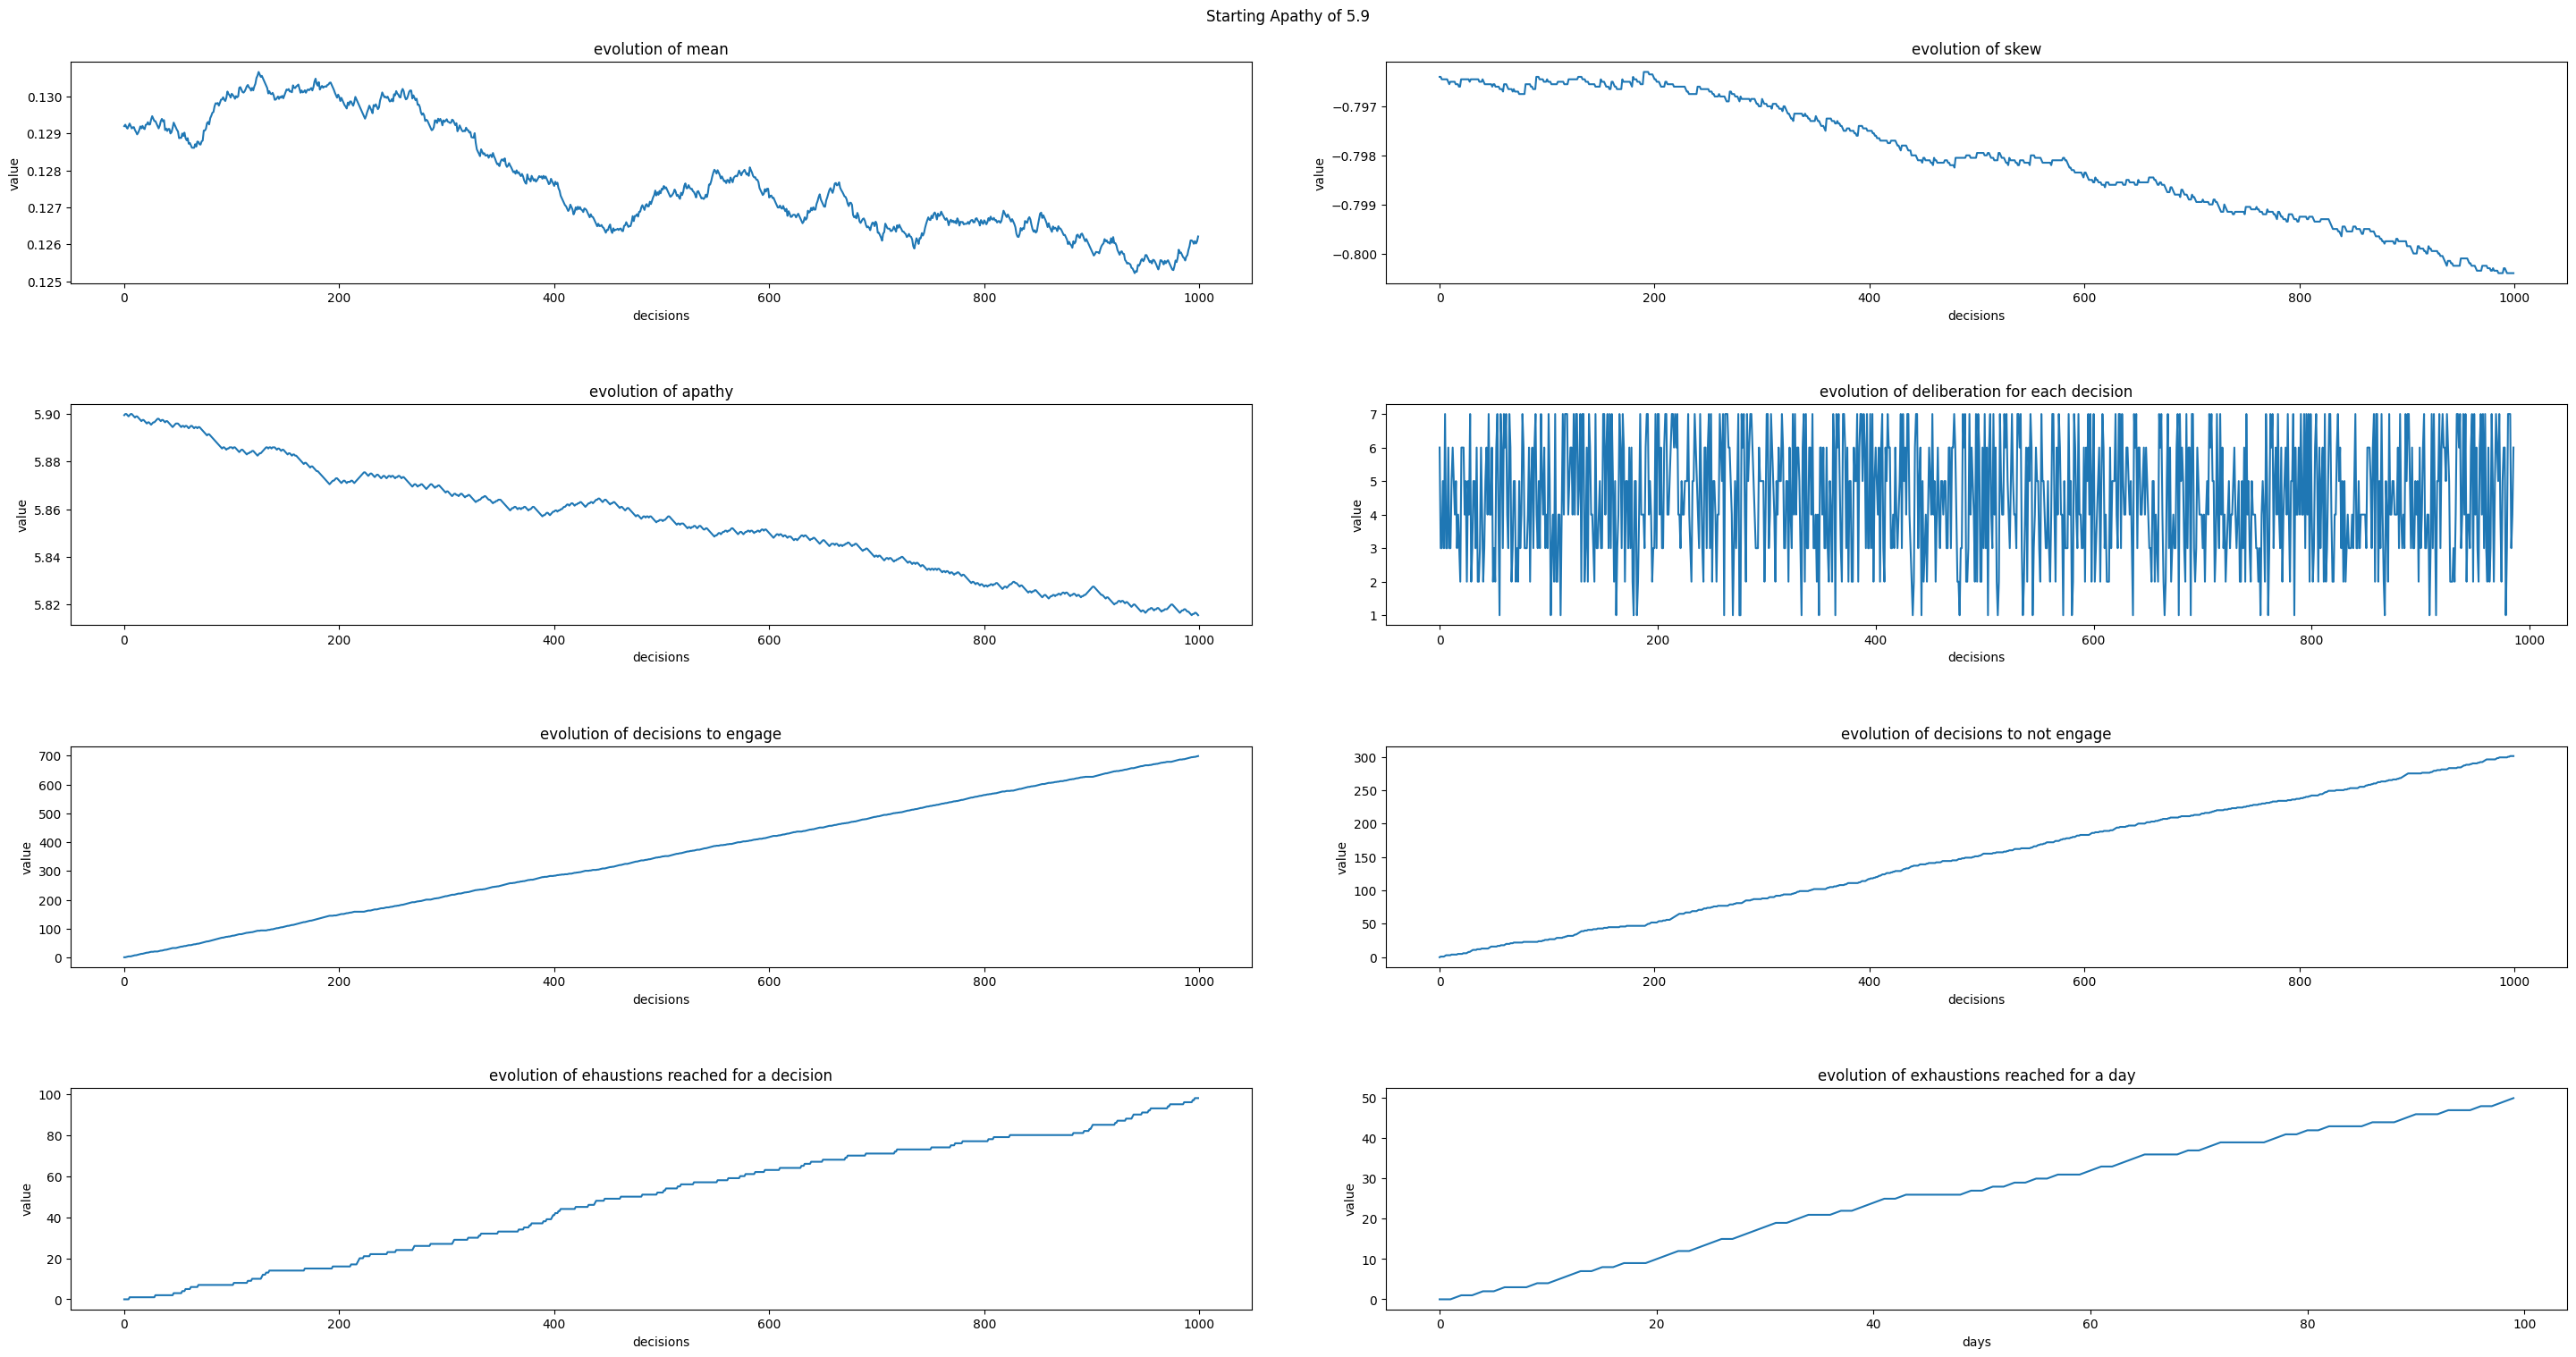

In [24]:
#Simulation_driver(6.5, 1000,f_ADM=[200,400],f_CBT=[250,400])
Simulation_driver(5.9,100)
#5.9 the lowest apathy that does not self recover
#Can recover  6.5, stagnate a 7
#If apathy is my measure of MDD then it needs to change far more quickly